<a href="https://colab.research.google.com/github/Balaji91221/Basics-for-ML-python/blob/main/Rice_leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Check the tensorflow version

import tensorflow as tf


In [22]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch.transforms import ToTensorV2  # Use ToTensorV2 instead of ToTensor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [23]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [24]:
os.listdir('/content/drive/MyDrive/rice_leaf_diseases')

['Leaf smut', 'Bacterial leaf blight', 'Brown spot']

In [25]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [26]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Leaf smut')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

40
40
40


In [27]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=6, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=6, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=6, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

6
6
6


In [28]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
34
34


In [29]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(120, 2)
(102, 2)
(18, 2)


In [30]:
df_data['target'].value_counts()

brown_spot               40
leaf_smut                40
bacterial_leaf_blight    40
Name: target, dtype: int64

In [31]:
df_train['target'].value_counts()

leaf_smut                34
brown_spot               34
bacterial_leaf_blight    34
Name: target, dtype: int64

In [32]:
df_val['target'].value_counts()

bacterial_leaf_blight    6
leaf_smut                6
brown_spot               6
Name: target, dtype: int64

In [33]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(102, 4)
(18, 4)


In [34]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0330.jpg,1,0,0
1,DSC_0379.JPG,0,0,1
2,DSC_0301.JPG,0,1,0
3,DSC_0512.jpg,1,0,0
4,DSC_0111.jpg,0,1,0


In [35]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
18,DSC_0403.JPG,0,0,1
19,DSC_0119.jpg,0,1,0
20,DSC_0299.JPG,0,1,0
21,DSC_0508.jpg,1,0,0
22,DSC_0504.jpg,1,0,0


In [36]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0330.jpg,1,0,0
1,DSC_0379.JPG,0,0,1
2,DSC_0301.JPG,0,1,0
3,DSC_0512.jpg,1,0,0
4,DSC_0111.jpg,0,1,0


import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3352706931115178383, *['target_bacterial_leaf_blight'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3352706931115178383, *['target_brown_spot'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_3352706931115178383, *['target_leaf_smut'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3352706931115178383, *['target_bacterial_leaf_blight'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3352706931115178383, *['target_brown_spot'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3352706931115178383, *['target_leaf_smut'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_3352706931115178383, *['image'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_3352706931115178383, *[[['target_bacterial_leaf_blight', 'target_brown_spot'], ['target_brown_spot', 'target_leaf_smut']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_3352706931115178383, *['target_bacterial_leaf_blight', 'image'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_3352706931115178383, *['target_brown_spot', 'image'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_3352706931115178383 = autoviz.get_df('df_3352706931115178383')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_3352706931115178383, *['target_leaf_smut', 'image'], **{'inner': 'stick'})
chart

In [37]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [38]:
!ls

df_combined.csv.gz  df_train.csv.gz  df_val.csv.gz  drive  sample_data


In [39]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

!ls

df_combined.csv.gz  df_val.csv.gz  image_dir
df_train.csv.gz     drive	   sample_data


In [40]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:

    path = '/content/drive/MyDrive/rice_leaf_diseases/Leaf smut'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the brown_spot images
for fname in brown_spot_list:

    path = '/content/drive/MyDrive/rice_leaf_diseases/Brown spot'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:

    path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight'

      # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [41]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

120

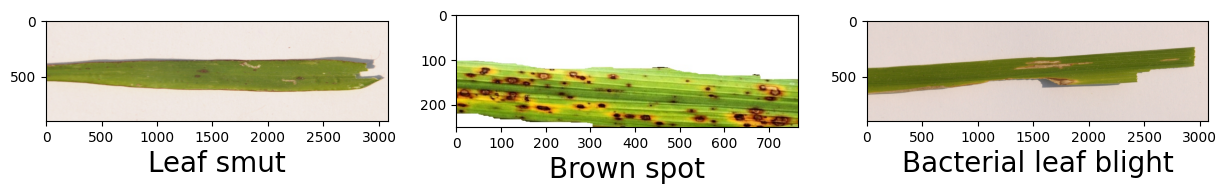

In [48]:
# Set up the canvas for the subplots
plt.figure(figsize=(15, 15))

# Image 1
plt.subplot(1, 3, 1)   # 1 row and 3 columns
item = 'DSC_0293.JPG'
path = '/content/drive/MyDrive/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1, 3, 2)   # 1 row and 3 columns
item = 'DSC_0100.jpg'
path = '/content/drive/MyDrive/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 3
plt.subplot(1, 3, 3)   # 1 row and 3 columns
item = 'DSC_0365.JPG'
path = '/content/drive/MyDrive/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()


In [49]:
import albumentations as albu


def augment_image(augmentation, image):

    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']


    return image_matrix

In [50]:
# Define the transforms


aug_types = albu.Compose([
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomGamma(),
                albu.RandomBrightnessContrast(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

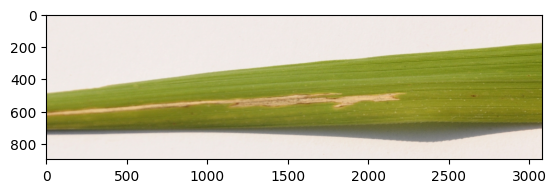

In [51]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[5]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

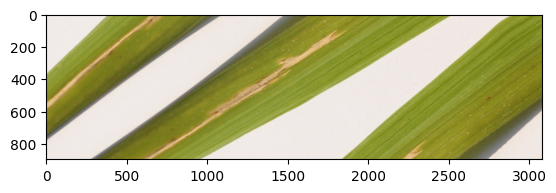

In [52]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

In [53]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
18,DSC_0403.JPG,0,0,1
19,DSC_0119.jpg,0,1,0
20,DSC_0299.JPG,0,1,0
21,DSC_0508.jpg,1,0,0
22,DSC_0504.jpg,1,0,0


In [54]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_train
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))




            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train)

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size


            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)

                # insert the image into X_train
                X_train[i] = aug_image



            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [55]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=120)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(102, 224, 224, 3)
(102, 3)


In [56]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1,

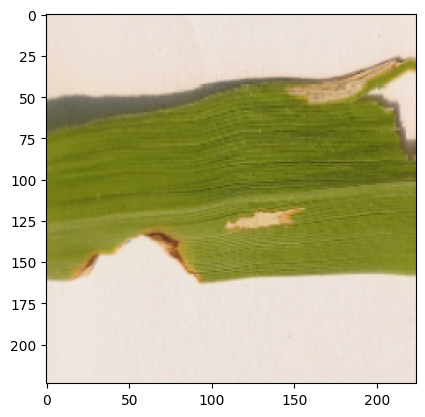

In [57]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

In [58]:
def val_generator(batch_size=5):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_val
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image




            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val)

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size





            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [59]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=120)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(18, 224, 224, 3)
(18, 3)


In [60]:
y_val

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

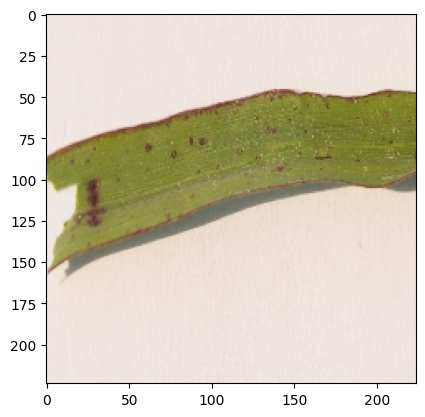

In [61]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

In [62]:
def test_generator(batch_size=1):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_test
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image



            # Normalize the images
            X_test = X_test/255

            yield X_test

In [63]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=120)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(18, 224, 224, 3)


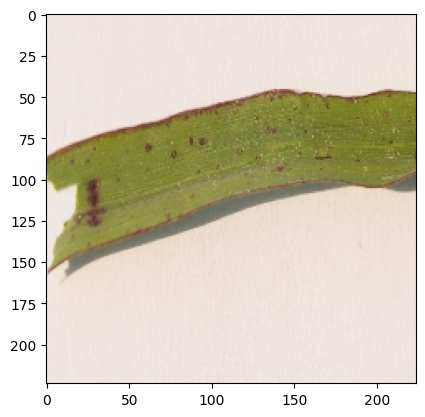

In [64]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)


In [65]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

In [66]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128  

In [67]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [73]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

# Set initial learning rate
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100*0.5,
    decay_rate=0.5,
    staircase=True)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set checkpoint path
filepath = "model.h5"

# Initialize callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min')
log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname, separator=',', append=False)

callbacks_list = [checkpoint, csv_logger, reduce_lr]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=val_gen,
    validation_steps=val_steps,
    verbose=1,
    callbacks=callbacks_list
)


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9608
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to model.h5
13/13 [==============================] - 50s 3s/step - loss: 0.1215 - accuracy: 0.9608 - val_loss: 0.2208 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9608
Epoch 2: val_accuracy did not improve from 0.88889
13/13 [==============================] - 24s 2s/step - loss: 0.1312 - accuracy: 0.9608 - val_loss: 1.5230 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9706
Epoch 3: val_accuracy did not improve from 0.88889

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
13/13 [==============================] - 24s 2s/step - loss: 0.0725 - accuracy: 0.9706 - val_loss: 1.6012 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/100
13/13 [=

In [74]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.960784,0.121492,0.888889,0.220795
1,1,0.960784,0.131223,0.833333,1.522957
2,2,0.970588,0.072535,0.833333,1.601233
3,3,0.950980,0.157590,0.833333,1.993323
4,4,0.990196,0.019280,0.833333,1.976167


In [75]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [76]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate(val_gen,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

18/18 [==============================] - 2s 116ms/step - loss: 0.2208 - accuracy: 0.8889
val_loss: 0.22079531848430634
val_acc: 0.8888888955116272


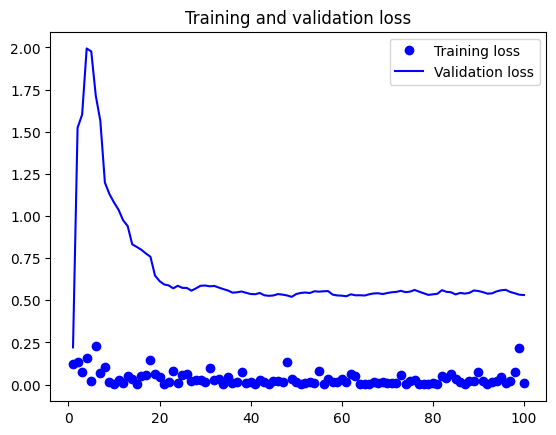

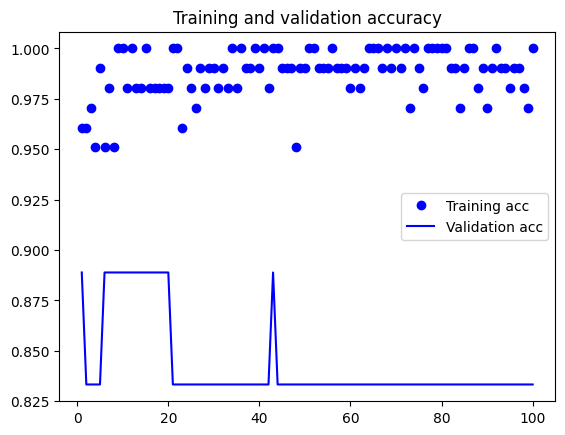

<Figure size 640x480 with 0 Axes>

In [77]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [78]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

<ipython-input-78-fa6b6bac86c9>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


18/18 [==============================] - 2s 59ms/step


In [79]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 2, 1, 0, 1, 0, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2])

In [80]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true)

y_true = np.argmax(y_true, axis=1)

y_true

array([0, 2, 1, 0, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2, 2, 0, 2])

In [81]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[0 2 1 0 1 0 1 1 2 0 2 2 1 1 2 2 1 2]
[0 2 1 0 1 0 1 1 2 0 2 0 1 1 2 2 0 2]


In [82]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[4 1 1]
 [0 6 0]
 [0 0 6]]


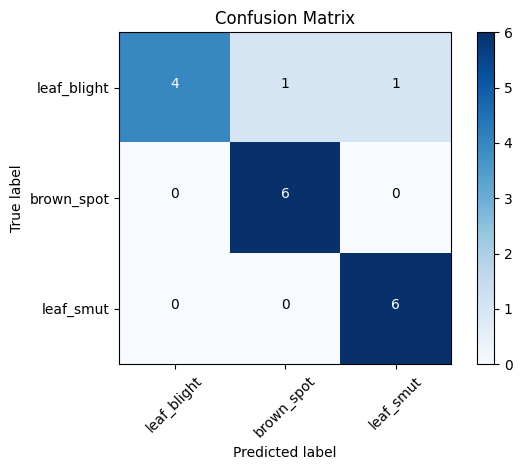

In [83]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [84]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.67      0.80         6
           brown_spot       0.86      1.00      0.92         6
            leaf_smut       0.86      1.00      0.92         6

             accuracy                           0.89        18
            macro avg       0.90      0.89      0.88        18
         weighted avg       0.90      0.89      0.88        18

